Theerawat Jindapoo
 
Atik Ilman Hossain
 
Pranav Devendra Bhagat

C:\Users\Admin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (328,336) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Admin\Anaconda3\lib\site-packages\pandas\core\indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1200)              121200    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1200)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1200)              1441200   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1200)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1200)              1441200   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1200)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


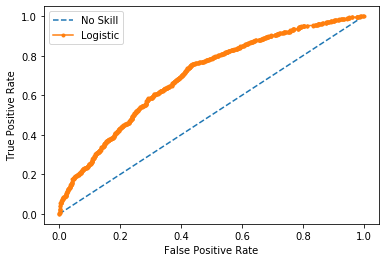

In [20]:
import numpy as np
import pandas as pd
import xlrd
import csv
from sklearn.utils import resample
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
import matplotlib as pyplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from matplotlib import pyplot

df = pd.read_csv("Data.csv")

# calculating Na in each column.
x = df.isna().sum()
y = x.sort_values(ascending = False)
na_index = y.index.tolist()
na_per = y.tolist()

dd = pd.DataFrame(list(zip(na_index, na_per)))
dd['percent'] = dd[1]/len(df)*100

# select only columns that have less than 90% of Na values.
na_90 = dd[dd['percent'] < 90]

selected_columns = na_90[0].tolist()
data = df.loc[:,selected_columns]

# balancing data.
data_flag_0 = data[data['Flag'] == 0]
data_flag_1 = data[data['Flag'] == 1]
data_flag_0_balance = resample(data_flag_0, replace = False, n_samples = 4100, random_state = 0)
balanced_data = pd.concat([data_flag_1, data_flag_0_balance])
balanced_data = balanced_data.reset_index(drop = True)

balanced_data_flag_0 = balanced_data[balanced_data['Flag'] == 0]
balanced_data_flag_1 = balanced_data[balanced_data['Flag'] == 1]

X = balanced_data.iloc[:,:-1]
Y = balanced_data["Flag"]
X_float = X.select_dtypes(include = ['float64'])
X_obj = X.select_dtypes(include = ['object'])

# change Na in categorical columns into it's mode.
for i in range(len(X_obj.columns)):
    x = X_obj.iloc[:,i].mode()
    X_obj.iloc[:,i] = X_obj.iloc[:,i].fillna(x[0])

# change Na in ordinal columns into 0.
X = pd.concat([X_float, X_obj], axis = 1)
X = X.fillna(0)

X_float = X.select_dtypes(include = ['float64'])
X_obj = X.select_dtypes(include = ['object'])

# Hot encoding.
dummy = pd.get_dummies(data = X_obj, drop_first = True)

hot_df = pd.concat([X_float, dummy, Y], axis = 1)
hot_X = hot_df.iloc[:,:-1]

# Normalizing data.
data_norm = (hot_X - hot_X.min()) / (hot_X.max() - hot_X.min())

# Use random forest to pick variables.
forest_method = RandomForestClassifier(n_estimators = 800, n_jobs = -1, random_state = 0)
forest_method.fit(data_norm, Y)
features = pd.DataFrame(forest_method.feature_importances_)

data_features = pd.concat([pd.DataFrame(data_norm.columns), features], axis = 1)
data_features.columns = ['variables','score']
data_features =  data_features.sort_values(by = ['score'], ascending = False)
top_100_features = data_features.nlargest(100,'score')
top_100_features = list(top_100_features['variables'])

selected_data = data_norm.loc[:,top_100_features]

# split data.
x_train, x_test, y_train, y_test = train_test_split(selected_data, Y, test_size=0.4, random_state=0)

y_train = keras.utils.to_categorical(y_train,2)
y_test = keras.utils.to_categorical(y_test,2)

# Deep NN.
model = Sequential()
model.add(Dense(1200,activation = 'relu', input_dim = 100))
model.add(Dropout(0.2))
model.add(Dense(1200, activation = 'relu')) 
model.add(Dropout(0.2))
model.add(Dense(1200, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation = 'softmax'))

model.compile(loss='binary_crossentropy', optimizer='RMSprop',metrics=['accuracy'])

summa = model.summary()

model.fit(x_train,y_train, batch_size = 256, epochs = 20, validation_split = 1/6, verbose=1)

test_loss, test_acc = model.evaluate(x_test, y_test)

pred = model.predict_classes(x_test)
RoundY=np.argmax(y_test, axis=1)

# confusion matrix and roc score.
confus = confusion_matrix(RoundY, pred)
print(confus)

trainX, testX, trainy, testy = train_test_split(data_norm, Y, test_size=0.25, random_state=2)
ns_probs = [0 for _ in range(len(testy))]
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
lr_probs = model.predict_proba(testX)
lr_probs = lr_probs[:, 1]
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()